In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from flux_utils import flux_conversion
from astropy import units as u
import numpy as np
from data import aeff_ehe_gfu, aeff_ehe, aeff_hese
from plots import fontsize, fig_width

In [2]:
# Simple approximation scaling from TXS 0506+056

# x = [200 * 10**12, 10*10.**15]
x = [100 * 10**12, 10*10.**15]


e_integral = np.log(x[1]/x[0])

ul_txs_6_month_flux = 5. * 10 **-11. * u.erg / (u.cm**2 * u.s)
ul_txs_6_month = ul_txs_6_month_flux /(flux_conversion/u.cm**2)

fluence = ((1./(x[0] * (1*(u.eV).to("erg")))) * u.erg * ul_txs_6_month_flux * (0.5 * u.year).to("s")/(u.erg**2.))
a_eff_ehe = (1./fluence).to("m2")
print(f"Effective area (EHE): {a_eff_ehe:.2f}")

# print(((e_integral * u.eV) / (ul_txs_6_month_flux * (0.5 * u.year).to("s"))).to("m2"))

ratio_ehe_alert = (6.6 + 2.8) / 2.1 # ICRC REALTIME PAPER RATIO GOLD TO EHE
ul_6_month_alert = ul_txs_6_month / ratio_ehe_alert

a_eff_alert = a_eff_ehe * ratio_ehe_alert
print(f"Effective area (Alert): {a_eff_alert:.2f}")

Effective area (EHE): 20.31 m2
Effective area (Alert): 90.90 m2


In [3]:
print(ul_txs_6_month * flux_conversion * (0.5 * u.year).to("s"))

0.0007889399999999999 erg


In [4]:
print(ratio_ehe_alert)

4.476190476190475


In [5]:
print(ul_6_month_alert*(0.5 * u.year).to("s"))

1.1679870814766889e+51 erg


In [6]:
ul_e = ul_6_month_alert * (0.5 * u.year).to("s")

In [7]:
print(ul_e)

1.1679870814766889e+51 erg


Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

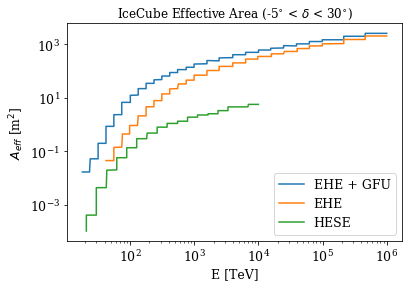

In [8]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"], label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"], label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"], label="HESE")
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$A_{eff}$ [m$^{2}$]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

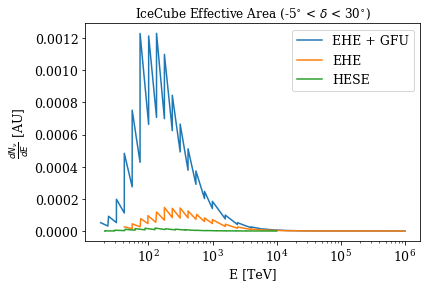

In [9]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2., label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"] * aeff_ehe["E_TeV"] **-2., label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"] * aeff_hese["E_TeV"] **-2. , label="HESE")
# plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\frac{dN_{\nu}}{dE}$ [AU]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

In [10]:
print(np.sum(aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2.))

0.014623465343435827


In [11]:
def integrate_aeff(aeff_df, power=2.0, e_min_gev=x[0]/(10.**9.), e_max_gev=x[1]/(10.**9.)):
    n_iter = int(len(aeff_df["E_TeV"])/int(2))

    a_eff = 0.
    
    for i in range(n_iter):
        lower = 2*i
        upper = 2*i + 1
        e_min = aeff_df["E_TeV"][lower] * 10**3
        e_max = aeff_df["E_TeV"][upper] * 10**3
        
        if np.logical_and(e_min > e_min_gev, e_min < e_max_gev):
        
            int_factor = (1./e_min**(power - 1.) - 1./e_max**(power - 1.)) * u.GeV
            aeff = np.mean([aeff_df["A_eff"][lower], aeff_df["A_eff"][upper]]) * u.m**2
            a_eff += int_factor * aeff
    
    return a_eff

In [12]:
power = 2.0

a_eff_vals = []
norms = []

int_energy = []

for i, aeff_df in enumerate([aeff_ehe_gfu, aeff_ehe, aeff_hese]):
    
    e_min_gev = x[0]/(10. ** 9.)
    e_max_gev = x[1]/(10. ** 9.)
    
    a_eff = integrate_aeff(aeff_df, power=power, e_min_gev=e_min_gev, e_max_gev=e_max_gev)

    norm_1gev = ((1.*u.GeV)**2./a_eff/(0.5*u.year)).to("erg cm^-2 s^-1")
    norm_100tev = norm_1gev * ((100 * u.TeV).to("GeV")/ u.GeV) ** -power
        
    norms.append(norm_1gev.to("GeV cm^-2 s^-1")/(1.* u.GeV**2))
    
    a_eff_vals.append(a_eff)
    
    if power == 2.0:
        int_factor = np.log(e_max_gev/e_min_gev)
        int_energy.append(int_factor)
    else:
        int_power = 2.0 - power
        int_factor = ((e_max ** int_power) - (e_min ** int_power))/(int_power)
        raise Exception("Integrate!")
        
    print(f"A flux normalisation of {norms[i]:.2g} is required for an expectation of one neutrino alert")
    print(f"A flux of {norm_1gev:.2g} at 1 GeV is required for an expectation of one neutrino alert")

print(f"Effective area increase EHE+GFU:EHE = {(a_eff_vals[0]/a_eff_vals[1]):.2f}")
print(r"This assumes an $E^{-" + str(f"{power:.2f}") + r"}$ Power Law")


A flux normalisation of 1e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.7e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 3.3e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 5.2e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 0.00012 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.9e-07 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
Effective area increase EHE+GFU:EHE = 3.17
This assumes an $E^{-2.00}$ Power Law


In [13]:
flux_t = norms[0] * (0.5*u.year).to("s")
print(f"Required time-integrated flux normalisation for one alert: {flux_t:.2g} at 1GeV")
print(f"Required fluence for one alert: {(flux_t * (int_energy[0] * u.GeV**2.)):.2g}")
fluence_erg = (flux_t * (int_energy[0] * u.GeV**2.)).to("erg cm^-2")
print(f"Required fluence for one alert: {fluence_erg:.2g}")

en = (((int_energy[0] * u.GeV**2. * flux_t)/(flux_conversion / u.cm**2)).to("erg"))
print(f"Required energy for one alert: {en:.2g}")

Required time-integrated flux normalisation for one alert: 0.16 1 / (cm2 GeV) at 1GeV
Required fluence for one alert: 0.75 GeV / cm2
Required fluence for one alert: 0.0012 erg / cm2
Required energy for one alert: 8e+51 erg


In [14]:
def expected_energy(f_a=0.1, baryon_loading=100.):
    return 7.3 * 10**48. * u.erg * f_a**(-12./19.) * baryon_loading **(11./16.)

def n_exp(f_a=0.1, baryon_loading=100.):
    return (expected_energy(f_a, baryon_loading).to("GeV")/(int_energy[0] * u.GeV**2. * flux_t.to("GeV^-1 cm^-2")/(flux_conversion / u.cm**2) )).to("")

In [15]:
n_exp(baryon_loading=100.)

<Quantity 0.09297716>